# Part 1) Match spine trace with extracellular spike trains

In this notebook, we show how to match the corresponding presynaptic cell for a given dendritic spine. More detailed explanation can be found in ...

First, the spike trains of all recorded units are convolved with an expotential kernel. This expotnetial kernel is constructed with parameters that fit the calcium indicator's dynamics. We then downsample the convolved spike trains in order to match the sampling rate of calcium imaging for postsynaptic cells.

Second, we extract the spine calcium trace from the imaging. We use robust regression to remove the contribution of dendritic activities from the spine calcium trace in order to obtain the synaptic responses.

Network synchrony (bursts) is detected and excluded for the following correlation analysis. We apply Pearson correlation to the spine calcium trace with convolved spike trains from all recorded units, and rank the correlation R values. In next notebook, we would show whether the unit with the highest R value should be accepted as the corresponding presynaptic cell for the given spine.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import roiextractors as re
import matplotlib.pyplot as plt
import spikeextractors as se
import belextractors as be
from pathlib import Path
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import quantities as pq
import neo as neo
from elephant.statistics import instantaneous_rate
from elephant import kernels
import scipy.signal as ss
import scipy.stats as stats
import scipy.ndimage as ndimg
import sys
import pynwb
import statsmodels.api as sm


%matplotlib notebook

/Users/xuexi/anaconda3/envs/measpine_mapping/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [54]:
import sys

sys.path.append("..")
from imaging_tools import *

# 1. Retrieve and load data

NWB files can be downloaded from DANDI Archive "".

In [30]:
# Load nwb files

nwb_file_path = ".." # location of downloaded nwb file
sorting, imag, imag_times, mea_times, mea_duration, ds_idxs = load_nwb_file(nwb_file_path)

#  2. Convolve extracellular spiketrains 

After loading the spike trains, we convolve them with an exponential decaying kernel to simulate the calcium response in a spine when an action potential is received.

In [31]:
# convert to Neo spiketrains for convolution
spiketrains = convert_to_neo(sorting, duration=mea_duration)

<IPython.core.display.Javascript object>


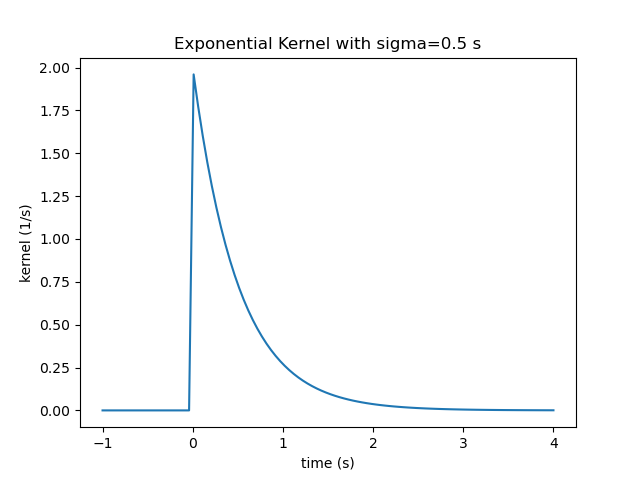

Text(0, 0.5, 'kernel (1/s)')

In [32]:
# Convolve spike train with exponential kernel that fits the indicator kinetics
fig_krn, ax_krn = plt.subplots()

time_array = np.linspace(-1, 4, num=100) * pq.s
kernel = kernels.ExponentialKernel(sigma=0.5*pq.s)
kernel_time = kernel(time_array)
ax_krn.plot(time_array, kernel_time)
ax_krn.set_title("Exponential Kernel with sigma=0.5 s")
ax_krn.set_xlabel("time (s)")
ax_krn.set_ylabel("kernel (1/s)")

Now we can convolve each spike train with the exponential kernel (this is done with the `instantanous_rate` function in `elephant` using the exponential kernel we previously computed). After convolution, we downsample the convolved signal by using the shutter indices (`ds_idxs`) and we apply the $\frac{\Delta F}{F}$ transform:

In [55]:
# convolve spiketrains with kernel and calculate delta F over F (for normalization and detrending)
individual_frs = []
n_downsamples = imag.get_num_frames()
individual_frs_ds = []
individual_frs_ds_dff = []
ts = np.linspace(0, mea_duration, n_downsamples)

# params for delta F over F with percentile filtering
PPRCTL = 25 
PLEN = 100

for i in tqdm(range(len(spiketrains)), desc="Computing istantaneous firing rates"):
    spt = spiketrains[i]
    ifr = instantaneous_rate(spt, sampling_period=spt.sampling_period, center_kernel=False, 
                             kernel=kernel).squeeze()
   
    ifr_ds = ifr[ds_idxs].magnitude.astype(float) # downsampling
    
    baseline = 1 # avoid dividing by 0
    ifr_ds_dff, ifr_ds_bl = dff(ifr_ds + baseline, 'winperc2', PLEN, PPRCTL)
    
    ifr_ds_dff[np.isnan(ifr_ds_dff)] = 0
    ifr_ds_dff[np.isinf(ifr_ds_dff)] = 0
    
    individual_frs.append(ifr)
    individual_frs_ds.append(ifr_ds)
    individual_frs_ds_dff.append(ifr_ds_dff) # the covolved downsampled (same length with imag data) and normalized MEA traces

Computing istantaneous firing rates: 100%|███████████████████████████████████████████████████| 78/78 [00:34<00:00,  2.23it/s]


<IPython.core.display.Javascript object>


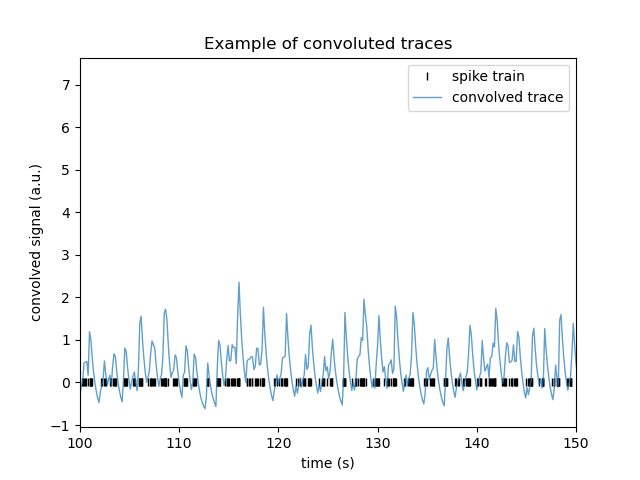

(100.0, 150.0)

In [56]:
# figure of an example of convolved trace
fig_conv, ax_conv = plt.subplots()

spike_id = 76 # type in a random unit id to check the convolved trace
ax_conv.plot(spiketrains[spike_id].times, np.zeros_like(spiketrains[spike_id].times), '|', color='k',lw=0.1,
             label="spike train")
ax_conv.plot(ts, individual_frs_ds_dff[spike_id],alpha = 0.7, lw=1, label="convolved trace")
ax_conv.set_title("Example of convoluted traces")
ax_conv.set_xlabel("time (s)")
ax_conv.set_ylabel("convolved signal (a.u.)")
ax_conv.legend()
ax_conv.set_xlim([100, 150])

# 3. Extract Ca$^{2+}$ traces from imaging

Here we extract the spine Ca$^{2+}$ traces and their adjacent dendritic shaft traces from the imaging. We can manually select multiple potential activated spines by drawing the ROIs and extract imaging data accordingly.

<IPython.core.display.Javascript object>


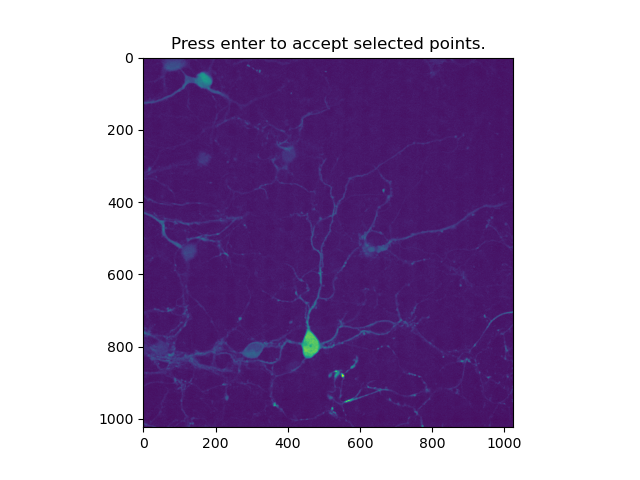

In [36]:
# load imag and manually select spine and adjacent dendritic shaft 
# multiple rois can be drawn at once for different spines and their adjacent dendritic shafts
# the drawing order has to be: spine1,adjacent shaft of spine1, spine2, adjacent shaft of spine2, ...
# example data can be loaded from nwb file below
avg_im = compute_avg_video(imag, stride=500)
rois = select_rois(avg_im) # select spines and respective shafts, in sequence 

In [37]:
LOAD_DATA = True # if load fluorescence traces from nwb file

In [38]:
if LOAD_DATA:
    print("Loading pre-computed Ca2+ traces")
    with pynwb.NWBHDF5IO(nwb_file_path, "r") as io:
        read_nwbfile = io.read()
        rois_response = read_nwbfile.processing['ophys']['Fluorescence']['RoiResponseSeries'].data[:]
        trace_spine = np.transpose(rois_response)[0]
        trace_shaft = np.transpose(rois_response)[1]
        dfspine, blspine = dff(trace_spine, 'winperc2', PLEN, PPRCTL) # same params for percentile filter as for spiketrains
        dfshaft, blshaft = dff(trace_shaft, 'winperc2', PLEN, PPRCTL)

        traces_dff_spine = dfspine    
        traces_dff_shaft = dfshaft
        traces_bl_spine = blspine   
        traces_bl_shaft = blshaft

else:
    traces_raw_spine = []
    traces_raw_shaft = []

    traces_dff_spine = []
    traces_bl_spine = []
    traces_dff_shaft = []
    traces_bl_shaft = []
    for i, (spine, shaft) in enumerate(zip(rois[::2], rois[1::2])):
        trace_spine = extract_roi_activity(imag, spine)
        trace_shaft = extract_roi_activity(imag, shaft)
        dfspine, blspine = dff(trace_spine, 'winperc2', PLEN, PPRCTL)
        dfshaft, blshaft = dff(trace_shaft, 'winperc2', PLEN, PPRCTL)
        traces_raw_spine.append(trace_spine)
        traces_raw_shaft.append(trace_shaft)
        traces_dff_spine.append(dfspine)
        traces_dff_shaft.append(dfshaft)
        traces_bl_spine.append(blspine)
        traces_bl_shaft.append(blshaft)

    traces_raw_spine = np.array(traces_raw_spine)    
    traces_raw_shaft = np.array(traces_raw_shaft)
    traces_dff_spine = np.array(traces_dff_spine)    
    traces_dff_shaft = np.array(traces_dff_shaft)
    traces_bl_spine = np.array(traces_bl_spine)    
    traces_bl_shaft = np.array(traces_bl_shaft)

Loading pre-computed Ca2+ traces


<IPython.core.display.Javascript object>


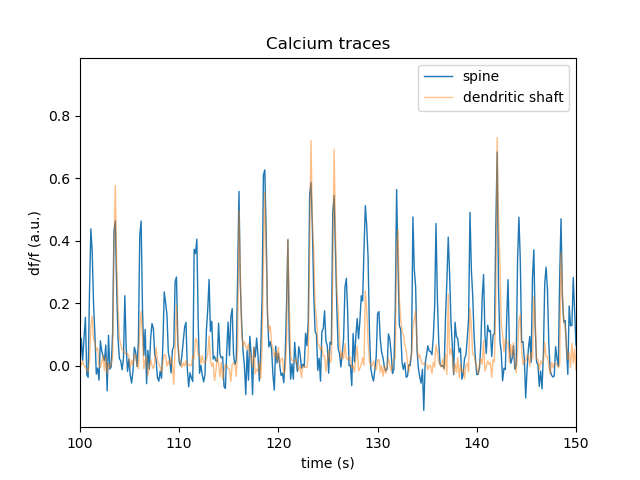

(100.0, 150.0)

In [39]:
fig_cal, ax_cal = plt.subplots()
# plot spine and dendritic traces
if LOAD_DATA:
    dff_spine = traces_dff_spine.copy()
    dff_shaft = traces_dff_shaft.copy()
else:
    dff_spine = traces_dff_spine[0].copy()
    dff_shaft = traces_dff_shaft[0].copy()    
    
ax_cal.plot(ts, dff_spine, label="spine", alpha = 1, lw=1)
ax_cal.plot(ts, dff_shaft, label="dendritic shaft", alpha=0.5, lw=1)
ax_cal.set_title("Calcium traces")
ax_cal.set_xlabel("time (s)")
ax_cal.set_ylabel("df/f (a.u.)")
ax_cal.legend()
ax_cal.set_xlim([100, 150])

# 4. Exclusion of network and local synchrony

Since the synchrony between spike trains will affect the correlation results strongly, we need to first detect the synchrony at network level and exclude the synchronized events. 

We first indentify and trim overactive units, as a unit that is hyper-active and continuously spiking will add complexity to any burst detector. Therefore, we need to detect such units and remove them before the burst detection.

<IPython.core.display.Javascript object>


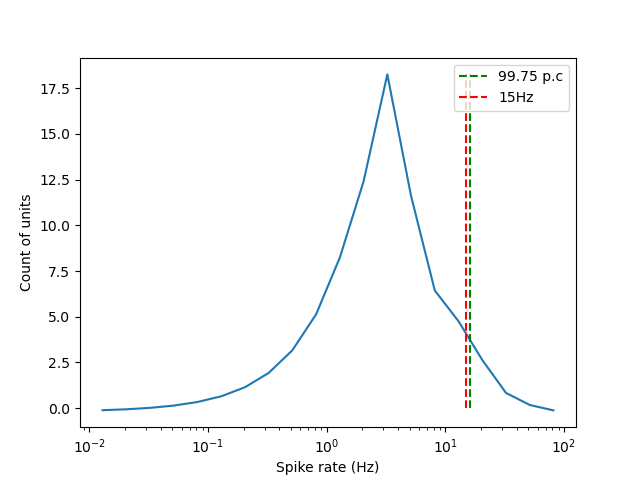

In [40]:
## Fiter hyperactive channels

# calculate spike rate of units
single_unit_rates = []
for i in range(len(spiketrains)):
    single_unit_rates.append(len(spiketrains[i].times) / mea_duration)
single_unit_rates = np.array(single_unit_rates)

# compare the cutoff spike rates of percentile and a fixed value
cutoff_pc = 99.75 # default percentile
cutoff_hz = 15 # default fixed value

logBins = np.power(10,np.arange(-2,2.2,0.2))
numChans = np.histogram(single_unit_rates, bins=logBins)[0]

lowess = sm.nonparametric.lowess # smoothing data with lowess method
y = lowess(numChans, np.convolve(logBins,[0.5,0.5])[1:-1])[:,1] 


plt.figure()
plt.semilogx(np.convolve(logBins,[0.5,0.5])[1:-1],y)
plt.vlines(np.percentile(single_unit_rates,cutoff_pc), 0, np.max(y), colors='green', linestyles='dashed', label=f'{cutoff_pc} p.c', data=None)
plt.vlines(cutoff_hz, 0, np.max(y), colors='red', linestyles='dashed', label=f'{cutoff_hz}Hz', data=None)
plt.xlabel('Spike rate (Hz)')
plt.ylabel('Count of units')
plt.legend()

In [41]:
# Decide the method used for cutoff (percentile or fixed value?)
PC = True
Hz = False

if PC:
    high_fr_units_id = np.where(single_unit_rates >= np.percentile(single_unit_rates,cutoff_pc))[0]
if Hz:
    high_fr_units_id = np.where(single_unit_rates >= cutoff_hz)[0]

# remove the over active units for burst detection
spikes_all_units = []
spikes_unit_id = []
for i in range(len(spiketrains)):
    if i not in high_fr_units_id:
        spikes_all_units.append(spiketrains[i].times)
        spikes_unit_id.append([i]*len(spiketrains[i].times))
        
spikes_all_units = np.concatenate(spikes_all_units)
spikes_all_units_sort = np.sort(spikes_all_units)
spikes_id = np.concatenate(spikes_unit_id)[np.argsort(spikes_all_units)]

Here we implement the burst detector based on global firing rate, the default setting of percentile threshold is 97 and for baseline is 85 percentile.

In [42]:
# Burst detector based on global firing rate
threshold_pctl = 97 # default parameter
baseline_pctl = 85 # default parameter


bin_width_s = 10e-3
bin_vector = np.arange(0,np.round(mea_duration)+bin_width_s,bin_width_s)
time_vector = np.convolve(bin_vector, [0.5,0.5])[1:-1]

spikes_per_bin = np.histogram(spikes_all_units_sort, bins=bin_vector)[0]
spikes_per_bin_sm = lowess(spikes_per_bin,np.arange(len(spikes_per_bin)),frac=0.0002)[:,1]
threshold_rate = np.percentile(spikes_per_bin,threshold_pctl)
baseline_rate = np.percentile(spikes_per_bin, baseline_pctl)

peaks = detect_peaks(spikes_per_bin,mph=threshold_rate,mpd=50e-3/bin_width_s)
peak_prominences = ss.peak_prominences(spikes_per_bin,peaks)[0]
peak_pass_threshold = np.where(peak_prominences > np.percentile(spikes_per_bin,threshold_pctl))[0]

In [43]:
# Find start and end times for bursts
peak_times_ind = peaks[peak_pass_threshold]
NetBurst_count = len(peak_times_ind)
NetBurst_start = np.zeros(NetBurst_count)
NetBurst_end = np.zeros(NetBurst_count)
NetBurst_spikeCount = np.zeros(NetBurst_count)
NetBurst_unitCount = np.zeros(NetBurst_count)
                               
for burst_i in range(NetBurst_count):
    ionset = peak_times_ind[burst_i] - np.where(np.flipud(spikes_per_bin_sm[0:peak_times_ind[burst_i]]) <= baseline_rate)[0][0] + 1
    ioffset = peak_times_ind[burst_i] + np.where(spikes_per_bin_sm[peak_times_ind[burst_i]::] <= baseline_rate)[0][0] - 1
    tonset = time_vector[ionset]
    toffset = time_vector[ioffset]
    imask = (spikes_all_units_sort >= tonset) & (spikes_all_units_sort <= toffset) + 0
    NetBurst_start[burst_i] = tonset
    NetBurst_end[burst_i] = toffset
    NetBurst_spikeCount[burst_i] = np.count_nonzero(imask)
    NetBurst_unitCount[burst_i] = len(np.unique(spikes_id[np.where(imask == 1)[0]]))

# Trimming edge cases -- bursts whose edges are beyond the data duration
if any(NetBurst_start == 0) == True:
    ind = np.where(NetBurst_start == 0)[0]
    NetBurst_start = np.delete(NetBurst_start,ind)
    NetBurst_end = np.delete(NetBurst_end,ind)
    NetBurst_spikeCount = np.delete(NetBurst_spikeCount,ind)
    NetBurst_count = NetBurst_count - np.count_nonzero(ind)
    NetBurst_unitCount = np.delete(NetBurst_unitCount, ind)
    
if any(NetBurst_end == 0) == True:
    ind = np.where(NetBurst_end == 0)[0]
    NetBurst_start = np.delete(NetBurst_start,ind)
    NetBurst_end = np.delete(NetBurst_end,ind)
    NetBurst_spikeCount = np.delete(NetBurst_spikeCount,ind)
    NetBurst_count = NetBurst_count - np.count_nonzero(ind)
    NetBurst_unitCount = np.delete(NetBurst_unitCount, ind)

In [44]:
# Expunging bursts with zero spikes
# This could occur as an artifact of using the smoothed vector to detect burst edges

if any(NetBurst_spikeCount == 0) == True:
    empty_mask = np.where(NetBurst_spikeCount == 0)[0]
    NetBurst_start = np.delete(NetBurst_start,empty_mask)
    NetBurst_end = np.delete(NetBurst_end,empty_mask)
    NetBurst_spikeCount = np.delete(NetBurst_spikeCount,empty_mask)
    NetBurst_count = NetBurst_count - len(empty_mask)
    NetBurst_unitCount = np.delete(NetBurst_unitCount, empty_mask)

In [45]:
# Second pass to merge overlapping bursts
min_ibi_ms = 75 #minimum interburst interval in ms. If smaller intervals are found, the involved bursts will be merged.

tmp_IBI = (NetBurst_start[1::] - NetBurst_end[0:-1])
i_negt = np.where(tmp_IBI < min_ibi_ms*1e-3)[0]
nOverlap = len(i_negt)
NetBurst_end[i_negt] = NetBurst_end[i_negt+1]
NetBurst_start[i_negt+1] = np.nan
NetBurst_end[i_negt+1] = np.nan
NetBurst_spikeCount[i_negt+1] = 0
NetBurst_unitCount[i_negt+1] = 0

for i in range(nOverlap):
    tonset = NetBurst_start[i_negt[i]]
    toffset = NetBurst_end[i_negt[i]]
    imask1 = (spikes_all_units_sort >= tonset) & (spikes_all_units_sort <= toffset) + 0
    NetBurst_spikeCount[i_negt[i]] = np.count_nonzero(imask1)
    NetBurst_unitCount[i_negt[i]] = len(np.unique(spikes_id[np.where(imask1 == 1)[0]]))
    

NetBurst_start = NetBurst_start[~np.isnan(NetBurst_start)]
NetBurst_end = NetBurst_end[~np.isnan(NetBurst_end)]
NetBurst_spikeCount = NetBurst_spikeCount[np.nonzero(NetBurst_spikeCount)[0]]
NetBurst_count = NetBurst_count - nOverlap
NetBurst_unitCount = NetBurst_unitCount[np.nonzero(NetBurst_unitCount)[0]]

In [46]:
# Compute IBI and Burst Width
NetBurst_IBI_s = np.concatenate((np.nan,NetBurst_start[1::]-NetBurst_end[0:-1]),axis = None)
NetBurst_burstWidth_ms = (NetBurst_end - NetBurst_start) * 1e3

In [ ]:
# optinal (to remove small bursts)
# if any (NetBurst_burstWidth_ms < 50) == True:
#     ind2 = np.where(NetBurst_burstWidth_ms < 50)[0]
#     NetBurst_start = np.delete(NetBurst_start,ind2)
#     NetBurst_end = np.delete(NetBurst_end,ind2)
#     NetBurst_spikeCount = np.delete(NetBurst_spikeCount,ind2)
#     NetBurst_count = NetBurst_count - len(ind2)
#     NetBurst_unitCount = np.delete(NetBurst_unitCount, ind2)
#     NetBurst_burstWidth_ms = np.delete(NetBurst_burstWidth_ms, ind2)    

In [47]:
# Compute peak recruitment within burst -- how many units are included in each bursting period
peakRecruitment_bin_width_s = 5e-3
peakRecruitment_numUnit = np.zeros((NetBurst_count))

for burst_i in range(NetBurst_count):
    imask = (spikes_all_units_sort >= NetBurst_start[burst_i]) & (spikes_all_units_sort <= NetBurst_end[burst_i])+0
    bin_vector = np.arange(NetBurst_start[burst_i],NetBurst_end[burst_i],peakRecruitment_bin_width_s)
    recruitment = np.histogram(spikes_all_units_sort[np.nonzero(imask)[0]], bins = bin_vector)[0]
    bin_id = find_bin_id(recruitment)
    pkid = np.argmax(recruitment)
    units_in_burst = spikes_id[np.where(imask==1)[0]]
    peakRecruitment_numUnit[burst_i] = len(np.unique(units_in_burst[np.where(bin_id==pkid)[0]]))

In [48]:
# Get indices to exclude network bursts for convolved traces and calcium traces
Burst_start_ex = NetBurst_start - 0.1 # extended times of bursting period to fit the calcium indicator dynamics
Burst_end_ex = NetBurst_end + 0.5

ex_burst = []
bs = np.transpose(Burst_start_ex)
be = np.transpose(Burst_end_ex)

for i, (st,e) in enumerate(zip(bs,be)):
       for n in range(len(ts)-1):
            if ts[n] > st and ts[n] < e:
                ex_burst.append(n)
                
allidx = np.arange(len(trace_spine))
keep_network_idxs = np.where(~np.in1d(allidx, ex_burst))[0] 

<IPython.core.display.Javascript object>


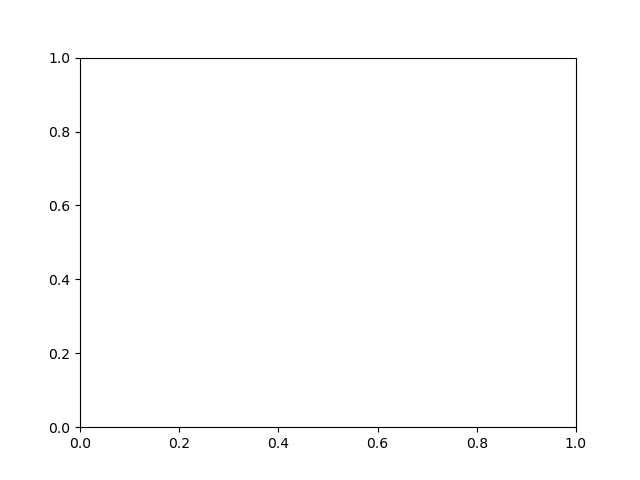

AttributeError: 'NwbSortingExtractor' object has no attribute 'get_num_segments'

In [49]:
import spikeinterface.widgets as sw
fig_burst, ax_burst = plt.subplots()
_ = sw.plot_rasters(sorting, ax=ax_burst, time_range=(50, 100))

for s, e in zip(bs, be):
    ax_burst.axvspan(s, e, color='y', alpha=0.5, lw=0)

_ = ax_burst.set_yticklabels([])

# 5. Demixing dendritic signal from spine response

The raw spine calcium trace contains not only synaptic activations but also dendritic signals, which is strong interference to correlating a spine to the corresponding presynaptic cell. Here we implemented robust regression to isolate the spine-specific signal,in order to get a clearer correlation with the presynaptic spike train.

<IPython.core.display.Javascript object>


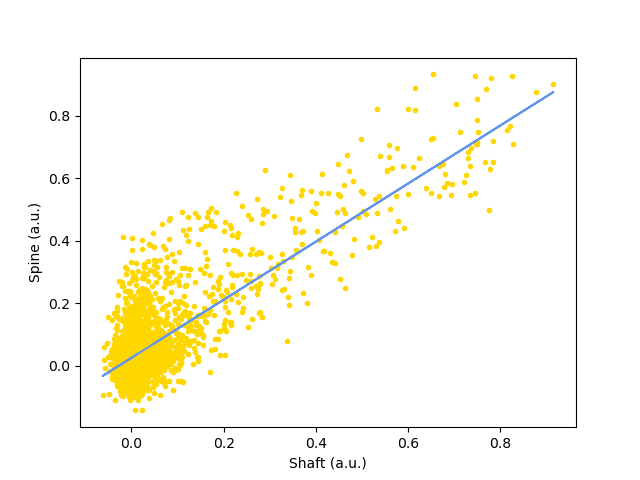

In [50]:
# Demixing using robust fit (ref: https://www.nature.com/articles/nature23019/figures/4)

traces_spine_dm = []
traces_shaft_contrib = []
traces_slope = []

if LOAD_DATA:
    DM_REF = traces_dff_shaft.copy()
    DM_TARGET = traces_dff_spine.copy()
else:
    DM_REF = traces_dff_shaft[0].copy()
    DM_TARGET = traces_dff_spine[0].copy()    

# here we use traces with network burst exclusion for demixing
dm_spine, shaft_contrib, slope, offset = demix_spine_shaft(DM_REF, DM_TARGET,
                                                           method='huber', 
                                                           plot_fit=True) 

traces_spine_dm.append(dm_spine)
traces_shaft_contrib.append(shaft_contrib)
traces_slope.append(slope)
    
traces_spine_dm = np.array(traces_spine_dm)
traces_shaft_contrib = np.array(traces_shaft_contrib)
traces_slope = np.array(traces_slope)

[76 30 67 40 43]
[0.52348414 0.31071733 0.24985068 0.23916037 0.18396663]


<IPython.core.display.Javascript object>


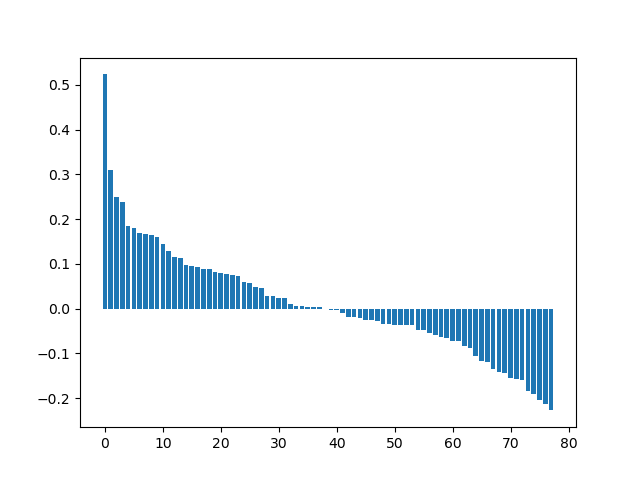

<BarContainer object of 78 artists>

In [51]:
# Perform correlation for spine response with recorded units

corr = np.zeros(len(individual_frs_ds_dff))


for i, ifr in enumerate(individual_frs_ds_dff):
              
    rval, pval = stats.pearsonr(ifr[keep_network_idxs], traces_spine_dm[0][keep_network_idxs]) 
    corr[i] = rval                                            
       
        
best_idxs = np.argsort(corr[:])[::-1][0:5] # get indices of the first 5 best match

print(best_idxs)
print(corr[best_idxs]) # print correlation r-value from the first 5 best match

best_unit = best_idxs[0]

# bar plot of sorted correlation r-value between the spine response and all recorded MEA spiketrains (high --> low)
plt.figure() 
plt.bar(x=np.arange(len(corr[:])), height=corr[np.argsort(corr[:])].ravel()[::-1])

<IPython.core.display.Javascript object>


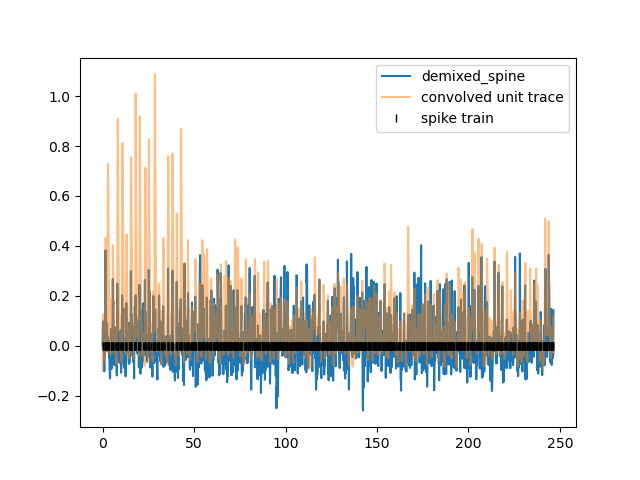

In [52]:
# check the demixed spine response and convolved trace from the best match
plt.figure()
shaft_contribution_full = slope * DM_REF + offset
demixed_spine_full = DM_TARGET - shaft_contribution_full
unit = individual_frs_ds_dff[best_unit].copy()

n = 0.15 # unit trace need a scaling factor because the linear summation of multiple spikes, adjustable
plt.plot(ts,demixed_spine_full,label = 'demixed_spine')
plt.plot(ts, unit*n, alpha = 0.5, label = 'convolved unit trace') 
plt.plot(spiketrains[best_unit].times, np.zeros_like(spiketrains[best_unit].times), '|', color='k',lw=0.1,
             label="spike train")
plt.legend()

# 6. Save data for next parts

To continue with next part, save all variables needed.

In [53]:
np.savez('saved_data_P1.npz', spiketrains = spiketrains, best_match=best_unit, best_r=corr[best_unit], second_match=best_idxs[1],
          individual_frs_ds_dff=individual_frs_ds_dff, keep=keep_network_idxs) 

/Users/xuexi/anaconda3/envs/measpine_mapping/lib/python3.8/site-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)
